# we need to go deeper 


The most straightforward way of improving the performance of deep neural networks is by increasing their size. This includes both increasing the depth – the number of levels – of the network and its 
but this mean bigger prameter size and this lead to overfitting specialy if we have limited data 

### so what we can do 
The fundamental way of solving both issues would be by ultimately moving from fully connected
to sparsely connected architectures,


In [ ]:
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten ,Concatenate , ReLU , Input

## we will start with the inception block 

In [ ]:
class inception_block(tf.keras.Model) : 
  def __init__(self, n_filters ):
    # n_filter is dictionary contain all the units for the block
    super(inception_block , self).__init__()
    # this the first (1,1) conv layer 
    self.conv_1 = Conv2D(n_filters['c1'] ,(1,1) , padding ='SAME')

    # this (1,1 ) conv to reduce the dimentions 
    self.conv_2_reduce = Conv2D(n_filters['c3_reduce'] , (1,1) , padding='SAME')
    # this (3,3) conv layer 
    self.conv_2 = Conv2D(n_filters['c2'] , (3,3) , padding ='SAME')

    # this (1,1 ) conv to reduce the dimentions
    self.conv_3_reduce = Conv2D(n_filters['c3_reduce'] , (1,1) , padding ='SAME')
    self.conv_3 = Conv2D(n_filters['c3'] , (5,5) , padding='SAME')

    self.max_pool = MaxPooling2D((3,3) ,padding ='SAME', strides=(1,1))
    self.pool_conv_reduce = Conv2D(n_filters['pool_reduce'] , (1,1) ,padding ='SAME')

    self.concat = Concatenate() # concat layer 
    self.relu = ReLU() 
  def call(self , inputs ) : 
    X = inputs
    X_1 = self.conv_1(X)
    X_2 = self.conv_2_reduce(X)
    X_2 = self.conv_2(X_2)
    X_3 = self.conv_3_reduce(X)
    X_3 = self.conv_3(X_3)
    X_4 = self.max_pool(X)
    X_4 = self.pool_conv_reduce(X_4)
    outputs = self.concat([X_1 , X_2 ,X_3 , X_4])
    outputs = self.relu(outputs)
    return outputs

## this the network which they use 

this really deep network and powerful one 
you can see the layers table which contain all the information about the network in the paper 

In [ ]:
inputs = Input((224,224,3))

convolution_1 = Conv2D(64 , (7,7) , strides=(2,2) , padding='same' , activation ='relu')(inputs)
pool_1 = MaxPooling2D((3,3) , strides =(2,2) , padding='same')(convolution_1)

convolution_2 = Conv2D(192 , (3,3) , strides=(1,1) , padding='same' , activation ='relu')(pool_1)
pool_2 = MaxPooling2D((3,3) , strides =(2,2), padding='same')(convolution_2)

inception_3a = inception_block({'c1' : 64 , 'c2_reduce' : 96 , 'c2': 128 , 'c3_reduce' : 16 , 'c3' : 32 , 'pool_reduce' : 32})(pool_2)
inception_3b = inception_block({'c1' : 128 , 'c2_reduce' : 128 , 'c2': 192 , 'c3_reduce' : 32 , 'c3' : 96 , 'pool_reduce' : 64})(inception_3a)
pool_2 = MaxPooling2D((3,3) , strides =(2,2) , padding='same')(inception_3b)

inception_4a = inception_block({'c1' : 192 , 'c2_reduce' : 96 , 'c2': 208 , 'c3_reduce' : 16 , 'c3' : 48 , 'pool_reduce' : 64})(pool_2)

# this side branch output 
branch_1_avg_pool = tf.keras.layers.AveragePooling2D((5,5) ,strides =(3,3))(inception_4a) 
branch_1_conv_reduce = Conv2D(128 , (1,1) , padding ='same' ,activation ='relu')(branch_1_avg_pool)
branch_1_fc = Dense(1024, activation ='relu')(branch_1_conv_reduce )
branch_1_dropout = tf.keras.layers.Dropout(.7)(branch_1_fc) 
branch_1_output = Dense(1000 , activation ='relu')(branch_1_dropout)

inception_4b = inception_block({'c1' : 160 , 'c2_reduce' : 112 , 'c2': 224, 'c3_reduce' : 24 , 'c3' : 64 , 'pool_reduce' : 64})(inception_4a)
inception_4c = inception_block({'c1' : 128 , 'c2_reduce' : 128 , 'c2': 256, 'c3_reduce' : 24 , 'c3' : 64 , 'pool_reduce' : 64})(inception_4b)
inception_4d = inception_block({'c1' : 112 , 'c2_reduce' : 144 , 'c2': 288, 'c3_reduce' : 32 , 'c3' : 64 , 'pool_reduce' : 64})(inception_4c)

# this another side branch output 
branch_2_avg_pool = tf.keras.layers.AveragePooling2D((5,5) ,strides =(3,3))(inception_4d) 
branch_2_conv_reduce = Conv2D(128 , (1,1) , padding ='same' ,activation ='relu')(branch_2_avg_pool)
branch_2_fc = Dense(1024, activation ='relu')(branch_2_conv_reduce )
branch_2_dropout = tf.keras.layers.Dropout(.7)(branch_2_fc) 
branch_2_output = Dense(1000 , activation ='relu')(branch_2_dropout)

inception_4e = inception_block({'c1' : 256 , 'c2_reduce' : 160 , 'c2': 320, 'c3_reduce' : 32 , 'c3' : 128 , 'pool_reduce' : 128})(inception_4d)
pool_3 = MaxPooling2D((3,3) , strides =(2,2) , padding='same')(inception_4e)

inception_5a = inception_block({'c1' : 256 , 'c2_reduce' : 160 , 'c2': 320 , 'c3_reduce' : 32 , 'c3' : 128 , 'pool_reduce' : 128})(pool_3)
inception_5b = inception_block({'c1' : 384 , 'c2_reduce' : 192 , 'c2': 384, 'c3_reduce' : 48 , 'c3' : 128 , 'pool_reduce' : 128})(inception_5a)
avg_pool = tf.keras.layers.AveragePooling2D((7,7) ,strides =(1,1))(inception_5b)

drop = tf.keras.layers.Dropout(.4)(avg_pool) 
linear = Dense(1000, activation ='relu')(drop)
final_output = Dense(1000 ,activation ='softmax')(linear)
model =tf.keras.models.Model(inputs ,  [ branch_1_output , branch_2_output ,final_output]) 


In [ ]:
model.summary() # model summary 

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_201 (Conv2D)            (None, 112, 112, 64  9472        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_48 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_201[0][0]']             
 )                                                                                          

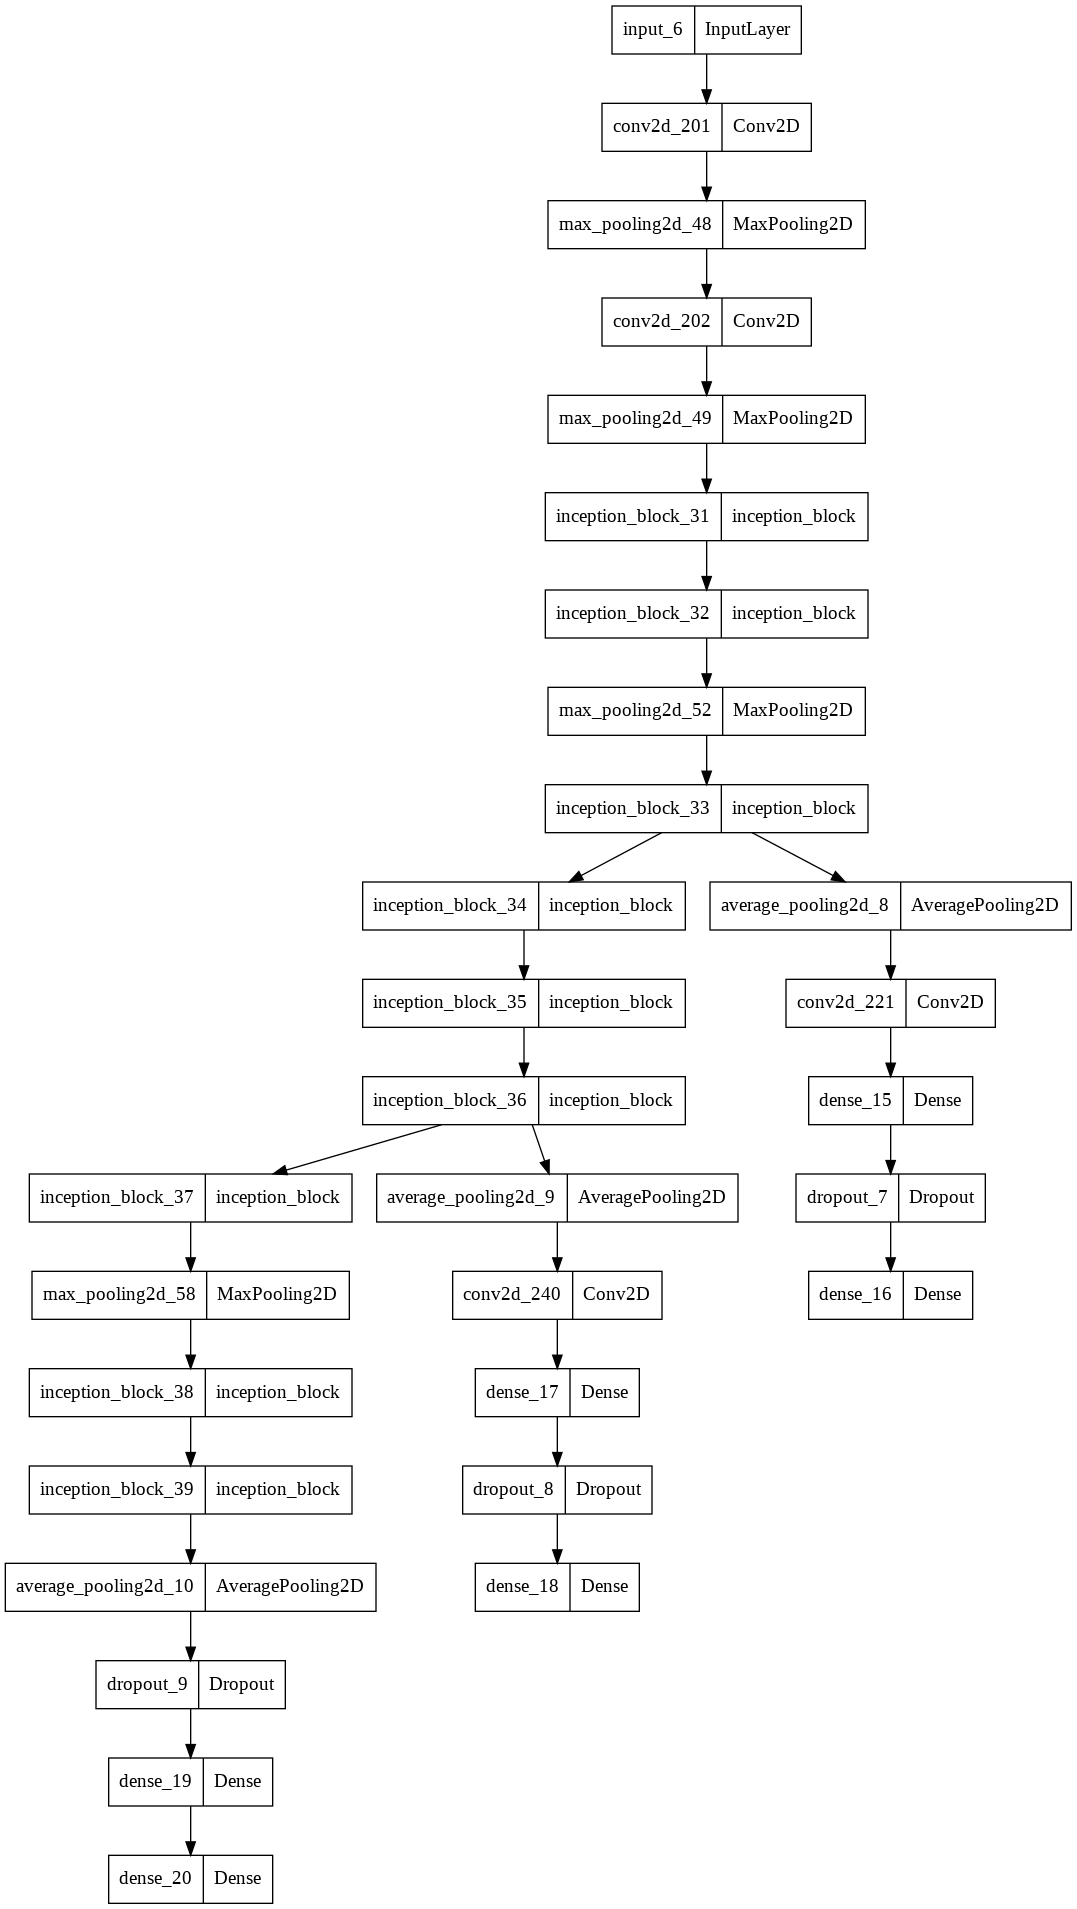

In [ ]:
tf.keras.utils.plot_model(model) # plot the model to see better picture 

## finaly you can compile the model and train it 